# <center>First Update on Group Project
# <center>[Safe Trade: Stock Prediction](https://github.com/breindy/SafeTrade)
Shofiqur Rahman<br>
Bashir Ahamed<br>
Michelle Uy<br>
Thierno Diallo<br><br>
Grant Long<br>
CSC.59970<br>
November 05, 2018</p>

With a lot of company stocks listed and a huge amount of trading done each working day we have an immense amoount of data at our hand. With that a problem comes is what we consider and what we discard as not necessary. Most importantly, what features do really impact stock prices. The first task is to come up with some features that effects stock prices. For that purpose, we will see correlation between stock price and each features we can find. The data will come from [IEX API](https://iextrading.com/developer/docs/)

Also with all the varieties of stock data at hand we realize that dealing with all the different company stocks together might not give us a woriking model for all company; a model appropriate to predict on one company stocks might not perform equally well on another company. So, initially our foucs is on to build a model that can predict well at least for a company, namely Apple Inc. or AAPL.

We also realize that pridicting an exact stock price depending on some regression model might be too bold. Instead, what we could do is to say, given the present state of the market, if the company stock price is going to rise or fall in near future (Probably, to be specific, in next three/four months). We might add to that by what percent the stock might rise. 

In [1]:
# Import necessary python modules to equip ourselves with better tools

# Import library for data manipulation
import pandas as pd
# Import pyhton http library
import requests
# To work with JSON objects returned from http calls
import json

# To get training and test data
from sklearn.model_selection import train_test_split
# To get the visualization tolls
import matplotlib.pyplot as plt


In [2]:
# All API calls to IEX is prefixed with this
iexUrl = 'https://api.iextrading.com/1.0'

# Testing: Making API call to see current price
response = requests.get(iexUrl + '/stock/GOOG/price')
print('API Call Success! \n Google Price: ' + response.text)

API Call Success! 
 Google Price: 1031.91


In [3]:
# Declaring the main dataframe that we will be manipulating throughout the model building
df = pd.DataFrame(columns=['date', 'company', 'symbol', 'dividend', 'eps', 'grossProfit', 'marketcap', 'pe', 'price', 'revenuePerShare'])


In [4]:
### Populating df with data for Apple Inc.
tempdf = pd.DataFrame(columns=['date', 'company', 'symbol', 'dividend', 'eps', 'grossProfit', 'marketcap', 'pe', 'price', 'revenuePerShare'])

# Making API call to get last one year end of day close price(target value) and transaction date for AAPL
response = requests.get(iexUrl + '/stock/aapl/chart/1y')
JSONdata = response.json()
date = list()
price = list()
for data in JSONdata:
    date.append(data['date'])
    price.append(data['close'])
tempdf.date = date
tempdf.price = price
tempdf.company = 'Apple Inc.'
tempdf.symbol = 'AAPL'

In [5]:
# Making API call to get last one year querterly EPS
response = requests.get(iexUrl + '/stock/aapl/earnings')
JSONdata = response.json()
totalEPS = 0 # to set the null EPS later

# Setting EPS values for transaction days that happened after the EPS reporting date
if 'earnings' in JSONdata:
    for data in JSONdata['earnings']:
        print(data)
        tempdf.loc[tempdf['date'] > data['EPSReportDate'], ['eps']] = data['actualEPS']
        totalEPS += data['actualEPS']
    
# Setting NaN values in EPS to avarage of last four EPS
tempdf.loc[pd.isnull(tempdf['eps']), ['eps']] = totalEPS / len(JSONdata['earnings'])


{'actualEPS': 2.91, 'consensusEPS': 2.79, 'estimatedEPS': 2.79, 'announceTime': 'AMC', 'numberOfEstimates': 12, 'EPSSurpriseDollar': 0.12, 'EPSReportDate': '2018-11-01', 'fiscalPeriod': 'Q4 2018', 'fiscalEndDate': '2018-09-30', 'yearAgo': 2.07, 'yearAgoChangePercent': 0.40579710144927555, 'estimatedChangePercent': 0.34782608695652184, 'symbolId': 11}
{'actualEPS': 2.34, 'consensusEPS': 2.17, 'estimatedEPS': 2.17, 'announceTime': 'AMC', 'numberOfEstimates': 10, 'EPSSurpriseDollar': 0.17, 'EPSReportDate': '2018-07-31', 'fiscalPeriod': 'Q3 2018', 'fiscalEndDate': '2018-06-30', 'yearAgo': 1.67, 'yearAgoChangePercent': 0.40119760479041916, 'estimatedChangePercent': 0.29940119760479045, 'symbolId': 11}
{'actualEPS': 2.73, 'consensusEPS': 2.69, 'estimatedEPS': 2.69, 'announceTime': 'AMC', 'numberOfEstimates': 10, 'EPSSurpriseDollar': 0.04, 'EPSReportDate': '2018-05-01', 'fiscalPeriod': 'Q2 2018', 'fiscalEndDate': '2018-03-31', 'yearAgo': 2.1, 'yearAgoChangePercent': 0.29999999999999993, 'esti

In [6]:
# Calculating pe
tempdf['pe'] = tempdf['price'] / tempdf['eps']


In [7]:
# Making API call to get last one year querterly dividends
response = requests.get(iexUrl + '/stock/aapl/dividends/1y')
JSONdata = response.json()
totalDividend = 0 # to set the null dividend later

# Setting dividend values for transaction days that happened after the dividend declaredDate
for data in JSONdata:
    tempdf.loc[tempdf['date'] > data['declaredDate'], ['dividend']] = data['amount']
    totalDividend += data['amount']
    
# Setting NaN values in dividend to avarage of last four dividend amount
tempdf.loc[pd.isnull(tempdf['dividend']), ['dividend']] = totalDividend / len(JSONdata)


In [8]:
# Making API call to get last one year marketcap and revenuePerShare
response = requests.get(iexUrl + '/stock/aapl/stats')
JSONdata = response.json()

tempdf['marketcap'] = JSONdata['marketcap']
tempdf['revenuePerShare'] = JSONdata['revenuePerShare']


In [9]:
# Making API call to get last one year grossProfit
response = requests.get(iexUrl + '/stock/aapl/financials?period=annual')
JSONdata = response.json()

totalgrossProfit = 0 # to set the null grossProfit later

# Setting grossProfit values for transaction days that happened after the grossProfit report date
for data in JSONdata['financials']:
    tempdf.loc[tempdf['date'] > data['reportDate'], ['grossProfit']] = data['grossProfit']
    totalgrossProfit += data['grossProfit']
    
# Setting NaN values in grossProfit to avarage of last four grossProfit
tempdf.loc[pd.isnull(tempdf['grossProfit']), ['grossProfit']] = totalgrossProfit / len(JSONdata['financials'])


In [10]:
# Concatenating Apple dataframe to the main dataframe df
df = pd.concat([df, tempdf], ignore_index=True)


In [11]:
# Save all stock data in a CSV file called 'StockData.csv'
df.to_csv('StockData.csv')


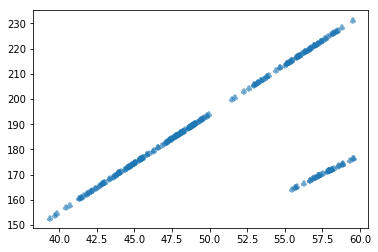

In [12]:
# Visualizig correlation between stock price and pe 
plt.scatter(df.pe, df.price, alpha=0.5, marker=r'$\clubsuit$')
plt.show()


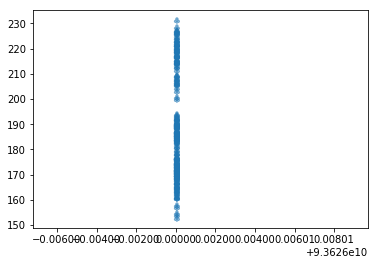

In [13]:
# Visualizig correlation between stock price and pe 
plt.scatter(df.grossProfit, df.price, alpha=0.5, marker=r'$\clubsuit$')
plt.show()

In [14]:
### Divide the DataFrame in X(Features) and Y(Target)
X = df[['dividend', 'eps', 'grossProfit', 'marketcap', 'pe', 'revenuePerShare']].copy()
Y = df.price

In [15]:
# Import train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split
# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier
# Import DecisionTreeRegressor from sklearn.tree
from sklearn.tree import DecisionTreeRegressor
# Import accuracy_score
from sklearn.metrics import accuracy_score
# Import mean_squared_error from sklearn.metrics as MSE
from sklearn.metrics import mean_squared_error as MSE

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

# min_samples_leaf tell the model to keep at least 10% data for each leaf
#SEED = 3
#dt = DecisionTreeRegressor(max_depth=6, min_samples_leaf=0.1, random_state=SEED)

# Fit dt to the training set
#dt.fit(X_train, y_train)

# Predict test set labels
#y_pred = dt.predict(X_test)
#print(y_pred[0:5])

# Compute test set accuracy: applicable only for classification model?
#acc = accuracy_score(y_test, y_pred)
#print("Test set accuracy: {:.2f}".format(acc))


In [16]:
# Instantiate dt
# min_samples_leaf tell the model to keep at least 10% data for each leaf
lr = DecisionTreeRegressor(max_depth=8,
             min_samples_leaf=0.1,
            random_state=3)

# Fit dt to the training set
lr.fit(X_train, y_train)

# Import mean_squared_error from sklearn.metrics as MSE
from sklearn.metrics import mean_squared_error as MSE

# Compute y_pred
y_pred = lr.predict(X_test)

# Compute mse_dt
mse_dt = MSE(y_test, y_pred)

# Compute rmse_dt
rmse_dt = mse_dt**(1/2)

# Print rmse_dt
print("Test set RMSE of dt: {:.2f}".format(rmse_dt))

# Compare Linear Regression with Logistic Regression
# Predict test set labels 
y_pred_lr = lr.predict(X_test)

# Compute mse_lr
mse_lr = MSE(y_test, y_pred_lr)

# Compute rmse_lr
rmse_lr = mse_lr**(1/2)

# Print rmse_lr
print('Linear Regression test set RMSE: {:.2f}'.format(rmse_lr))

# Print rmse_dt
print('Regression Tree test set RMSE: {:.2f}'.format(rmse_dt))


Test set RMSE of dt: 3.64
Linear Regression test set RMSE: 3.64
Regression Tree test set RMSE: 3.64


In [17]:
# The Generalization error tells us how much it generalizes on unseen data
# bias=underfitting and variance=overfitting

In [18]:
from sklearn.model_selection import cross_val_score

# Compute the array containing the 10-folds CV MSEs
MSE_CV_scores = - cross_val_score(lr, X_train, y_train, cv=10, 
                       scoring='neg_mean_squared_error',
                       n_jobs=-1)

# Compute the 10-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(RMSE_CV))

# Import mean_squared_error from sklearn.metrics as MSE
from sklearn.metrics import mean_squared_error

# Fit dt to the training set
#dt.fit(X_train, y_train)

# Predict the labels of the training set
y_pred_train = lr.predict(X_train)

# Evaluate the training set RMSE of dt
RMSE_train = (mean_squared_error(y_train, y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE: {:.2f}'.format(RMSE_train))


CV RMSE: 3.53
Train RMSE: 3.20


In [19]:
### To get the average performance of few models
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=3)

# Define the list classifiers
classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn)]
# Iterate over the pre-defined list of classifiers
#for clf_name, clf in classifiers:    
 
    # Fit clf to the training set
#    clf.fit(X_train, y_train)    
   
    # Predict y_pred
#    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
#    accuracy = accuracy_score(y_test, y_pred)

    # Evaluate clf's accuracy on the test set
    #print('{:s} : {:.3f}'.format(clf_name, accuracy))

# Instantiate a VotingClassifier vc
#vc = VotingClassifier(estimators=classifiers)     

# Fit vc to the training set
#vc.fit(X_train, y_train)   

# Evaluate the test set predictions
#y_pred = vc.predict(X_test)

# Calculate accuracy score
#accuracy = accuracy_score(y_test, y_pred)
#print('Classifier: {:.3f}'.format(accuracy))


In [20]:
# # To predict using n models of same kind
# # Import BaggingClassifier
# from sklearn.ensemble import BaggingClassifier

# # Instantiate dt
# dt = DecisionTreeClassifier(random_state=1)

# # Instantiate bc
# bc = BaggingClassifier(base_estimator=dt, n_estimators=50, random_state=1)

# # Fit bc to the training set
# bc.fit(X_train, y_train)

# # Predict test set labels
# y_pred = bc.predict(X_test)

# # Evaluate acc_test
# acc_test = accuracy_score(y_test, y_pred)
# print('Test set accuracy of bc: {:.2f}'.format(acc_test)) 


In [21]:
# ### To test the model on the left out sample for each model of same type
# # Import BaggingClassifier
# from sklearn.ensemble import BaggingClassifier

# # Instantiate dt
# dt = DecisionTreeClassifier(min_samples_leaf=8, random_state=1)

# # Instantiate bc
# bc = BaggingClassifier(base_estimator=dt, 
#             n_estimators=50,
#             oob_score=True,
#             random_state=1)

# # Fit bc to the training set 
# bc.fit(X_train, y_train)

# # Predict test set labels
# y_pred = bc.predict(X_test)

# # Evaluate test set accuracy
# acc_test = accuracy_score(y_test, y_pred)

# # Evaluate OOB accuracy
# acc_oob = bc.oob_score_

# # Print acc_test and acc_oob
# print('Test set accuracy: {:.3f}, OOB accuracy: {:.3f}'.format(acc_test, acc_oob))

Test set RMSE of rf: 0.58


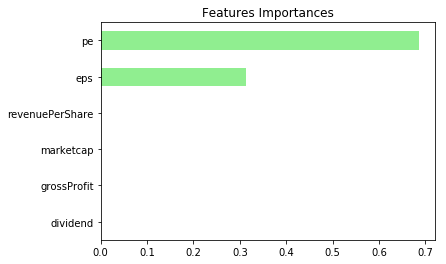

In [22]:
# Import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# Instantiate rf
rf = RandomForestRegressor(n_estimators=25,
            random_state=2)
            
# Fit rf to the training set    
rf.fit(X_train, y_train)

# Import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error as MSE

# Predict the test set labels
y_pred = rf.predict(X_test)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print rmse_test
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()


Things to consider: 
    stocks will tend to be correlated with each other